## Intro

Experiemnt run on 6/21/23 to evaluate if there are speed increase when trying to read the status of multiple channels when using multiple threads.

## Problem

It takes ~34 ms to read status for a single channel. This means reading status for 92 channels takes >3 s.

# Hypothesis 

Two theories as to what is happening:

1. Python is slow and reading the channels in series is the problem.

2. MacNet is slow and it's the problem.

# Experiment

Create a dedicated thread to read the status of each channel. 

# Result

It appears MacNet is slow. Creating dedicatd channels did not provide much improvement in speed. 


In [1]:
from pymacnet import ChannelInterface
import time
import queue
import threading
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]

pymacnet_channel_interface_config = {
    "server_ip": "3.3.31.83",
    "json_msg_port": 57570,
    "bin_msg_port": 57560,
    "msg_buffer_size_bytes": 4096,
    'channel': 5,
    'test_name': 'pymacnet_procedure_control',
    'test_procedure': 'test_procedure_1',
    'c_rate_ah': 1,
    'v_max_safety_limit_v': 4.2,
    'v_min_safety_limit_v': 2.9,
    'i_max_safety_limit_a': 2.0,
    'i_min_safety_limit_a': -2.0,
    'v_max_v': 4.2,
    'v_min_v': 3.0,
    'data_record_time_s': 1,
    'data_record_voltage_delta_vbys': 1,
    'data_record_current_delta_abys': 1,
}

In [2]:
channel_interface = ChannelInterface(pymacnet_channel_interface_config)

In [2]:
# Class used to run threads.
class ChannelThread():
    def __init__(self, channel_interface_config, channel, data_q) -> None:

        self.__channel = channel
        channel_interface_config['channel'] = channel
        self.__channel_interface = ChannelInterface(channel_interface_config)

        self.__data_q = data_q

        self.__start = False
        self.__read_status_thread = threading.Thread(
            target=self.__read_status_loop, args=(), daemon=True)
        self.__read_status_thread.start()

    def start(self):
        self.__start = True

    def __read_status_loop(self):
        while not self.__start:
            time.sleep(0)

        start_time = time.time()
        self.__channel_interface.read_channel_status()
        end_time = time.time()

        time.sleep(3)

        result_dict = {
            'channel' : self.__channel,
            'start_time_s' : start_time,
            'end_time_s' : end_time,
        }
        self.__data_q.put(result_dict)

    def stop(self):
        self.__read_status_thread.join()

In [3]:
num_channels = 50

data = queue.Queue()
channel_threads = []
for i in range(0,num_channels):
    channel_threads.append(
        ChannelThread(
            channel_interface_config = pymacnet_channel_interface_config,
            channel = i+1,
            data_q = data
        )
    )

# Sleep a bit after creating all threads
time.sleep(5)

start_sample = time.time()
for thread in channel_threads:
    thread.start()

for thread in channel_threads:
    thread.stop()

del channel_threads

data_points = []
while not data.empty():
    data_points.append(data.get())

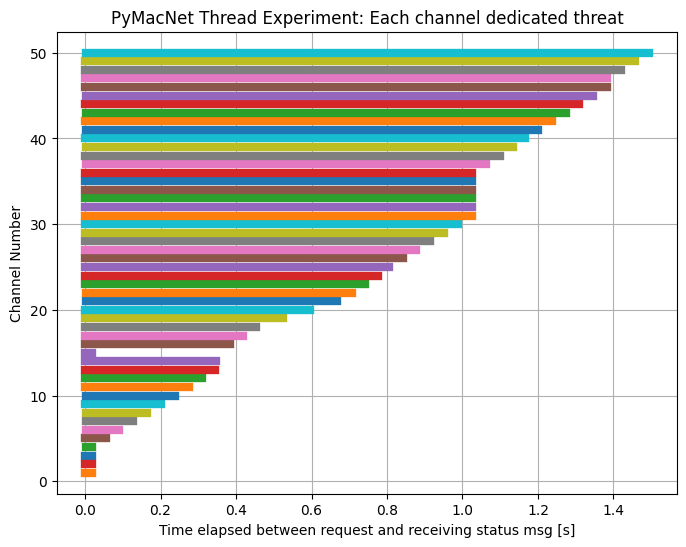

In [9]:
fig, ax = plt.subplots()
for data_point in data_points:
    ax.plot([data_point['start_time_s']-start_sample,data_point['end_time_s']-start_sample],
            [data_point['channel'],data_point['channel']],
            linewidth = 6)
        
ax.set_title("PyMacNet Thread Experiment: Each channel has dedicated thread and socket")
ax.set_ylabel('Channel Number')
ax.set_xlabel("Time elapsed between request and receiving status msg [s]")
ax.grid(True)

In [5]:
data_points

[{'channel': 3,
  'start_time_s': 1687372413.3932583,
  'end_time_s': 1687372413.4127598},
 {'channel': 1,
  'start_time_s': 1687372413.3936994,
  'end_time_s': 1687372413.412188},
 {'channel': 4,
  'start_time_s': 1687372413.3942747,
  'end_time_s': 1687372413.4127867},
 {'channel': 2,
  'start_time_s': 1687372413.3935087,
  'end_time_s': 1687372413.4122372},
 {'channel': 15,
  'start_time_s': 1687372413.3931718,
  'end_time_s': 1687372413.4121416},
 {'channel': 5,
  'start_time_s': 1687372413.3941653,
  'end_time_s': 1687372413.447443},
 {'channel': 6,
  'start_time_s': 1687372413.3949122,
  'end_time_s': 1687372413.4818058},
 {'channel': 7,
  'start_time_s': 1687372413.3946762,
  'end_time_s': 1687372413.5193715},
 {'channel': 8,
  'start_time_s': 1687372413.3949602,
  'end_time_s': 1687372413.5562665},
 {'channel': 9,
  'start_time_s': 1687372413.3934264,
  'end_time_s': 1687372413.5946915},
 {'channel': 10,
  'start_time_s': 1687372413.3947604,
  'end_time_s': 1687372413.630648},
